In [1]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
%load_ext autoreload
%autoreload 2
%matplotlib inline
from glob import glob
import h5py
import pandas as pd
import numpy as np
from scipy import misc

In [2]:
fl = glob('/bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/train/*.h5')

!mkdir -p /bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/train/images
!mkdir -p /bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/val/images

In [3]:
f = h5py.File(fl[0])

In [4]:
f.keys()

[u'HLF', u'Labels', u'Particles', u'Sources']

In [5]:
pf = f['Particles']

In [6]:
print pf.shape

(7500, 801, 18)


In [7]:
f['HLF']

<HDF5 dataset "HLF": shape (7500, 14), type "<f8">

In [8]:
f['Labels']

<HDF5 dataset "Labels": shape (7500, 3), type "<f8">

In [9]:
print f['Labels'][:5]

[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


In [10]:
features = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]

In [11]:
colors = {'isMu' : 'green',
         'isEle': 'blue',
         'isGamma':'red',
         'isChHad' : 'magenta',
         'isNeuHad': 'black'}

In [12]:
def get(f,ievent,ip,var):
    return f['Particles'][ievent,ip,features.index(var)]

In [13]:
def showEvent(f,ievent,itype='',show=True):
    max_eta = 5
    max_phi = np.pi
    plt.figure( figsize=(max_eta,max_phi),frameon=False)
    #plt.subplot(aspect='equal')
    for ip in range(pf.shape[1]): # Number of particles
        eta = get(f,ievent,ip,'Eta')
        phi = get(f,ievent,ip,'Phi')
        if eta==0 and phi==0: break
        #E = get(f,ievent,ip,'Energy')
        pT = get(f,ievent,ip,'Pt')
        #lE = max(np.log(E)/5.,0.001)
        lpT = max(np.log(pT)/5.,0.001)
        
        ptype = filter(None, [k for k in colors.keys() if get(f,ievent,ip,k)])
        if not ptype:
            print "no partible type",f['Particles'][ievent,ip,:]
            continue
        if ptype[0] == itype:
            if itype == 'isNeuHad':
                plt.gcf().gca().add_artist( plt.Circle((eta, phi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi+2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi-2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
            if itype == 'isChHad':
                plt.gcf().gca().add_artist( plt.Rectangle((eta, phi), lpT, lpT, color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Rectangle((eta, phi+2*np.pi), lpT, lpT, color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Rectangle((eta, phi-2*np.pi), lpT, lpT, color=colors[ptype[0]],  fill=False ) )
            else: # TODO: implement function to draw triangle, diamond, star etc.
                plt.gcf().gca().add_artist( plt.Circle((eta, phi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi+2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
                plt.gcf().gca().add_artist( plt.Circle((eta, phi-2*np.pi), lpT,color=colors[ptype[0]],  fill=False ) )
    plt.xlim((-max_eta,max_eta))
    plt.ylim((-max_phi,max_phi))
    plt.axis('off')
    if show: plt.show()

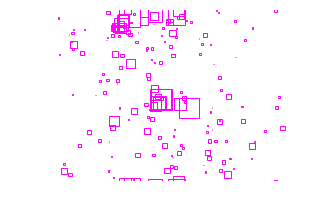

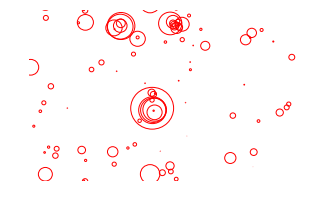

In [14]:
showEvent(f,109,'isChHad',show=True)
showEvent(f,109,'isGamma',show=True)

In [15]:
def transformEvent(f,ievent, show=True):
    img_collection = []
    for itype in [k for k in colors.keys()]:
        showEvent(f,ievent,itype,show)
        plt.savefig('fig.png', dpi=100,bbox_inches='tight', pad_inches=0)
        img = image = misc.imread('fig.png', mode='L') # 8-bit pixels, black and white
        img_collection.append(img)
    #print img.shape
    img_stack = np.stack(img_collection)
    #print img_stack.shape
    return img_stack

(5, 264, 421)
(264, 421)


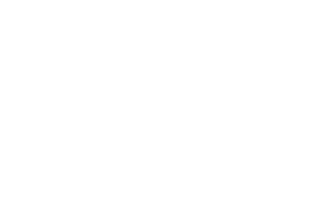

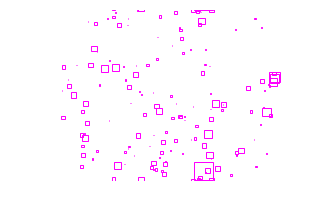

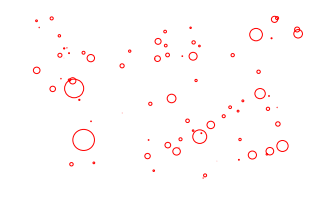

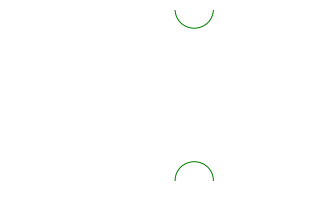

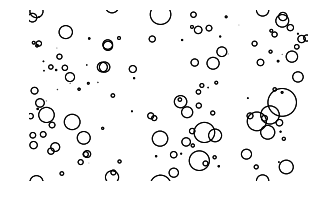

In [16]:
i = transformEvent(f,255,show=False)
print i.shape
print i[2].shape

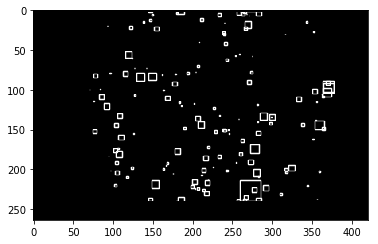

In [17]:
plt.imshow(i[1],cmap='gray_r')
plt.show()

In [ ]:
def transformDataset(f, limit=None):
    s = f['Particles'].shape
    newDataset = None
    for ievent in range(s[0]):
        if limit and ievent>=limit:break
        i = transformEvent(f,ievent, show=False)
        if newDataset is None:
            newDataset = np.zeros((s[0] if not limit else limit ,)+i.shape) # #png format
        newDataset[ievent,...] = i
        if (ievent%100==0): print "%d/%d"%(ievent,s[0])
    return newDataset

In [ ]:
d = transformDataset(f, 10)

0/7500


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [ ]:
def transformFile(fn, limit=None):
    
    ff = h5py.File(fn,'r')
    new_fn = fn.rsplit('/',1)[0]+'/images/'+fn.rsplit('/',1)[-1]
    print "Converting",fn,"into",new_fn,("for %s events"%limit) if limit else ""
    nd = transformDataset(ff, limit)
    fo = h5py.File(new_fn,'w')
    fo['Labels'] = ff['Labels'][:limit,...] if limit else ff['Labels']
    fo['Images'] = nd/255. ## normalize it
    fo.close()

In [ ]:
for fn in fl:
    transformFile(fn)